In [2]:
exp_dir = "firstfourth_lab"

In [3]:
do_imports()

In [4]:
data_path = "/datadrive/random_forests_clinical_data/"
csv_path = "/home/webvalley/score-machine-learning/Data/new_wScore.csv"
COLUMNS_BLACK_LIST = ['SCORE', 'esa_obi:sbp', 'esa_obi:dbp',
                      'ana_fis:smoking_recod', 'lab:glucose',
                      'lab:calculated_ldl',
                      'lab:total_cholesterol',
                      'ana:age']
headDic = {"lab":"lab:", "anapat": "ana_pat:", "esaobi": "esa_obi:", "ulttsa": "ult_tsa:"}

In [5]:
def read_data(csv_data_file):
    df = pd.read_csv(csv_data_file)
    df.sort_values("visit")
    df = df.select_dtypes(exclude=['object', 'datetime64'])
    df = df.drop(labels=COLUMNS_BLACK_LIST, axis=1)
    # Get rid of all columns with all -1 (NaN) and/or Zeros
    df = df[df.columns[df.max() > 0]]
    return df
def get_relevant_columns(foldername):
    heads = []
    for key in headDic:
        if key in foldername:
            heads.append(headDic[key])
    return heads
def select_columns_set(df, features_set):
    features = list(features_set)
    return df.columns[df.columns.str.startswith(tuple(features))].values

In [6]:
def bootstrap_ci(x, B=1000, alpha=0.05, seed=42):
    """Computes the (1-alpha) Bootstrap confidence interval
    from empirical bootstrap distribution of sample mean.

    The lower and upper confidence bounds are the (B*alpha/2)-th
    and B * (1-alpha/2)-th ordered means, respectively.
    For B = 1000 and alpha = 0.05 these are the 25th and 975th
    ordered means.
    """

    x_arr = np.ravel(x)

    if B < 2:
        raise ValueError("B must be >= 2")

    if alpha < 0 or alpha > 1:
        raise ValueError("alpha must be in [0, 1]")

    np.random.seed(seed)

    bmean = np.empty(B, dtype=np.float)
    for b in range(B):
        idx = np.random.random_integers(0, x_arr.shape[0]-1, x_arr.shape[0])
        bmean[b] = np.mean(x_arr[idx])

    bmean.sort()
    lower = int(B * (alpha * 0.5))
    upper = int(B * (1 - (alpha * 0.5)))

    return (bmean[lower], bmean[upper])

In [7]:
f = IntProgress(min=0, max=250, description='Loading... ', bar_style='success')
display(f)

feature_list = get_relevant_columns(exp_dir)
cols = select_columns_set(read_data(csv_path), feature_list)
folder_path = os.path.join(data_path, exp_dir)
feature_importance = np.zeros((5, 50, len(cols)))
for i in range(5):
    forest_path = os.path.join(folder_path, str(i))
    for forest_file in os.listdir(forest_path):
        if forest_file.endswith('pkl') and 'training' not in forest_file:
            forest_file_path = os.path.join(forest_path, forest_file)
            clf = pickle.load(open(forest_file_path, "rb"))
            feature_importance[i,f.value%50] = clf.feature_importances_
            f.value += 1

IntProgress(value=0, bar_style='success', description='Loading... ', max=250)

/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (125,222,223) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
borda_rankings = []
for importance in feature_importance:
    borda = borda_count((np.argsort(importance)))[0]
    borda_rankings.append(borda)

In [9]:
feature_confidence = np.zeros((5,len(cols),2))
for i in range(5):
    for j in range(len(cols)):
        f_imp = feature_importance[i, :, j]
        f_min_max = bootstrap_ci(f_imp)
        f_mean = np.mean(f_min_max)
        f_error = f_min_max[1] - f_mean
        feature_confidence[i,j] = (f_mean, f_error)

/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead


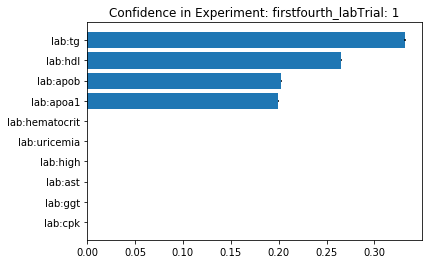

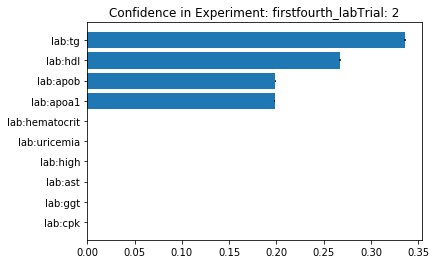

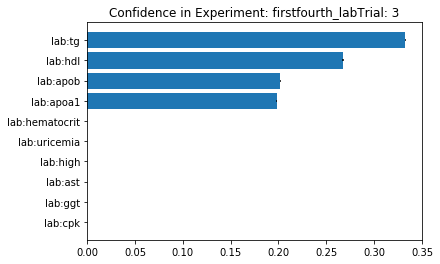

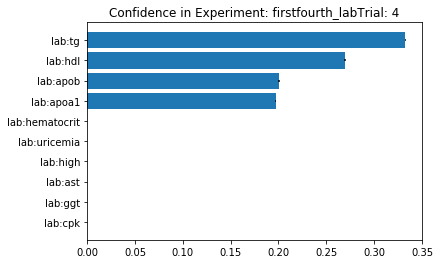

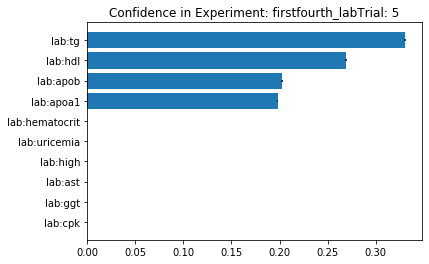

In [47]:
for i, confidence in enumerate(feature_confidence):
    fig = plt.figure()
    plt.title("Confidence in Experiment: " + exp_dir + "Trial: " + str(i+1))
    plt.barh(range(1,11), confidence[:,0][borda_rankings[i]][-10:], xerr=confidence[:,1][borda_rankings[i]][-10:])
    plt.yticks(range(1, 11), labels=cols[borda_rankings[i]][-10:])
    plt.savefig(os.path.join(folder_path, str(i) + "figure.png"), bbox_inches='tight')
    plt.show()

In [18]:
from bokeh.plotting import figure
from bokeh.io import curdoc, show, output_notebook
from bokeh.resources import CDN
output_notebook(CDN)

Loading BokehJS ...

In [23]:
for i, confidence in enumerate(feature_confidence):
    fig = figure(y_range = cols[borda_rankings[i]][-10:], plot_height=250, title= exp_dir + " Categorical Importance Run: " + str(i+1))
    fig.hbar(y = cols[borda_rankings[i]][-10:], right = confidence[:,0][borda_rankings[i]][-10:], height=0.2)
    show(fig)

In [49]:
reshaped_importanced = feature_importance.reshape((250, len(cols)))
borda = borda_count((np.argsort(reshaped_importanced)))[0]
feature_confidence = np.zeros((len(cols),2))
for j in range(len(cols)):
    f_imp = reshaped_importanced[:, j]
    f_min_max = bootstrap_ci(f_imp)
    f_mean = np.mean(f_min_max)
    f_error = f_min_max[1] - f_mean
    feature_confidence[j] = (f_mean, f_error)

/home/webvalley/anaconda3/envs/mlpy/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: This function is deprecated. Please call randint(0, 249 + 1) instead


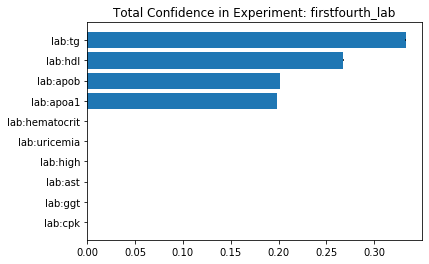

In [51]:
fig = plt.figure()
plt.title("Total Confidence in Experiment: " + exp_dir)
plt.barh(range(1,11), feature_confidence[:,0][borda][-10:], xerr=feature_confidence[:,1][borda][-10:])
plt.yticks(range(1, 11), labels=cols[borda][-10:])
plt.savefig(os.path.join(folder_path,"total_figure.png"), bbox_inches='tight')
plt.show()